In [2]:
import matplotlib.pyplot as plt
# 한글 폰트 지정
plt.rc("font", family = "Malgun Gothic")
# 스타일 서식 train
plt.style.use('ggplot')

# 마이너스 기호 표시 설정
plt.rcParams['axes.unicode_minus'] = False

In [16]:
# 필요한 라이브러리 임포트
# 데이터 처리 및 시각화 라이브러리
import pandas as pd
import seaborn as sns
import numpy as np
import random
import os
from matplotlib.pylab import rcParams  # 차트의 크기를 조절하기 위한 라이브러리

# 사이킷런 (scikit-learn) 라이브러리
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV  # 파라미터 설정 고민을 줄여주는 고마운 친구
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score  # loss function 커스터마이징
from sklearn.cluster import KMeans
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# 통계 및 시계열 분석 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose  # 시계열
from statsmodels.tsa.stattools import adfuller  # 정상성 테스트
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # PACF, ACF
from statsmodels.tsa.arima.model import ARIMA  # ARIMA 모델

# 머신러닝 라이브러리 (LightGBM, XGBoost)
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier, plot_tree

# 딥러닝 라이브러리 (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 기타
from pandas.plotting import autocorrelation_plot
from tqdm.auto import tqdm
import graphviz
import warnings
import shap
import ssl 
from pdpbox import info_plots

warnings.filterwarnings('ignore')

# 1. EDA⭐️

In [46]:
# 데이터 불러오기
sample_submission = pd.read_csv("C:\\Users\\USER\\projects\\2week\\sample_submission.csv")
train = pd.read_csv("C:\\Users\\USER\\projects\\2week\\train.csv",encoding='cp949')
test= pd.read_csv("C:\\Users\\USER\\projects\\2week\\test.csv",encoding='cp949')

In [47]:
# 복사본 생성
train_df = train.copy()
test_df = test.copy()

In [48]:
# 데이터 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [50]:
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [51]:
test_df.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

## 1.1 파생변수

In [52]:
# 'date_time' 열을 날짜/시간 형식으로 변환
train_df['date_time'] = pd.to_datetime(train_df['date_time'], format='%Y-%m-%d %H')

# month, day, time 새로운 열 추출 
train_df['month'] = train_df['date_time'].dt.month.astype(float)
train_df['day'] = train_df['date_time'].dt.day.astype(float)
train_df['time'] = train_df['date_time'].dt.hour.astype(float)

print(train_df.head())

   num           date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0    1 2020-06-01 00:00:00    8179.056    17.6      2.5   92.0      0.8   
1    1 2020-06-01 01:00:00    8135.640    17.7      2.9   91.0      0.3   
2    1 2020-06-01 02:00:00    8107.128    17.5      3.2   91.0      0.0   
3    1 2020-06-01 03:00:00    8048.808    17.1      3.2   91.0      0.0   
4    1 2020-06-01 04:00:00    8043.624    17.0      3.3   92.0      0.0   

   일조(hr)  비전기냉방설비운영  태양광보유  month  day  time  
0     0.0        0.0    0.0    6.0  1.0   0.0  
1     0.0        0.0    0.0    6.0  1.0   1.0  
2     0.0        0.0    0.0    6.0  1.0   2.0  
3     0.0        0.0    0.0    6.0  1.0   3.0  
4     0.0        0.0    0.0    6.0  1.0   4.0  


## 1.2 군집별 탐구 및 시각화

### 1.2.1 전력사용량 패턴 분석

Text(0.5, 1.0, '건물별 평균 전력사용량 분포')

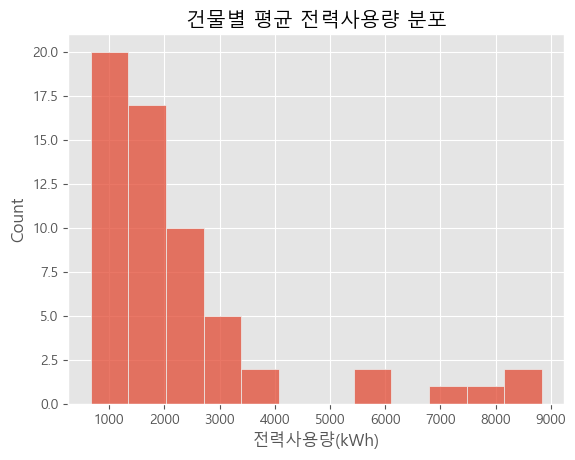

In [69]:
# 1. 건물별 '전력사용량' 평균 분포 시각화
sns.histplot(train_df.groupby('num')['전력사용량(kWh)'].mean())
plt.title('건물별 평균 전력사용량 분포')

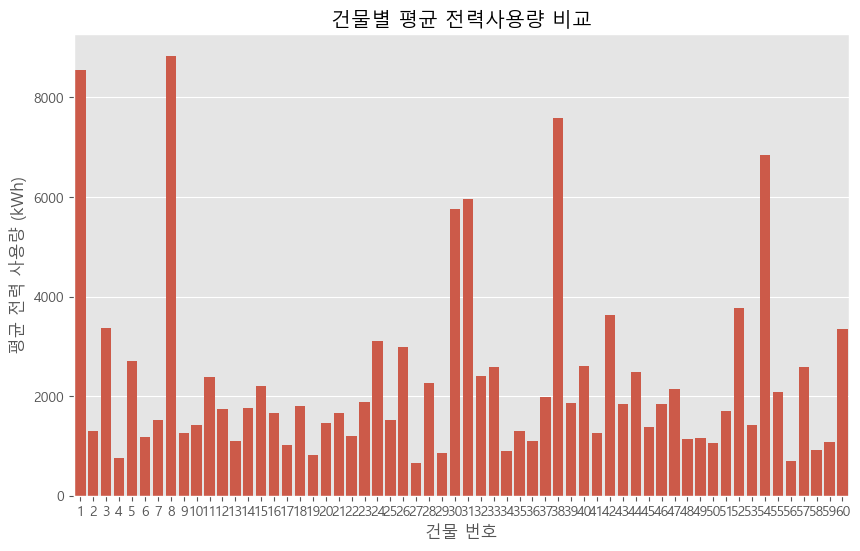

In [60]:
# 2. 건물별 평균 전력사용량 비교 시각화
mean_power_usage = train_df.groupby('num')['전력사용량(kWh)'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='num', y='전력사용량(kWh)', data=mean_power_usage)
plt.title('건물별 평균 전력사용량 비교')
plt.xlabel('건물 번호')
plt.ylabel('평균 전력 사용량 (kWh)')
plt.show()

### 1.2.2 태양광/비전기냉방설비운영 유무

#### 시각화

In [65]:
# 태양광/비전기냉방설비운영 유무 확인
solar_electric_df = train_df.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean().reset_index()
solar_electric_df

,비전기냉방설비운영,태양광보유,전력사용량(kWh)
0,0.0,0.0,2077.030506
1,0.0,1.0,1582.298192
2,1.0,0.0,2101.993590
3,1.0,1.0,2949.726621


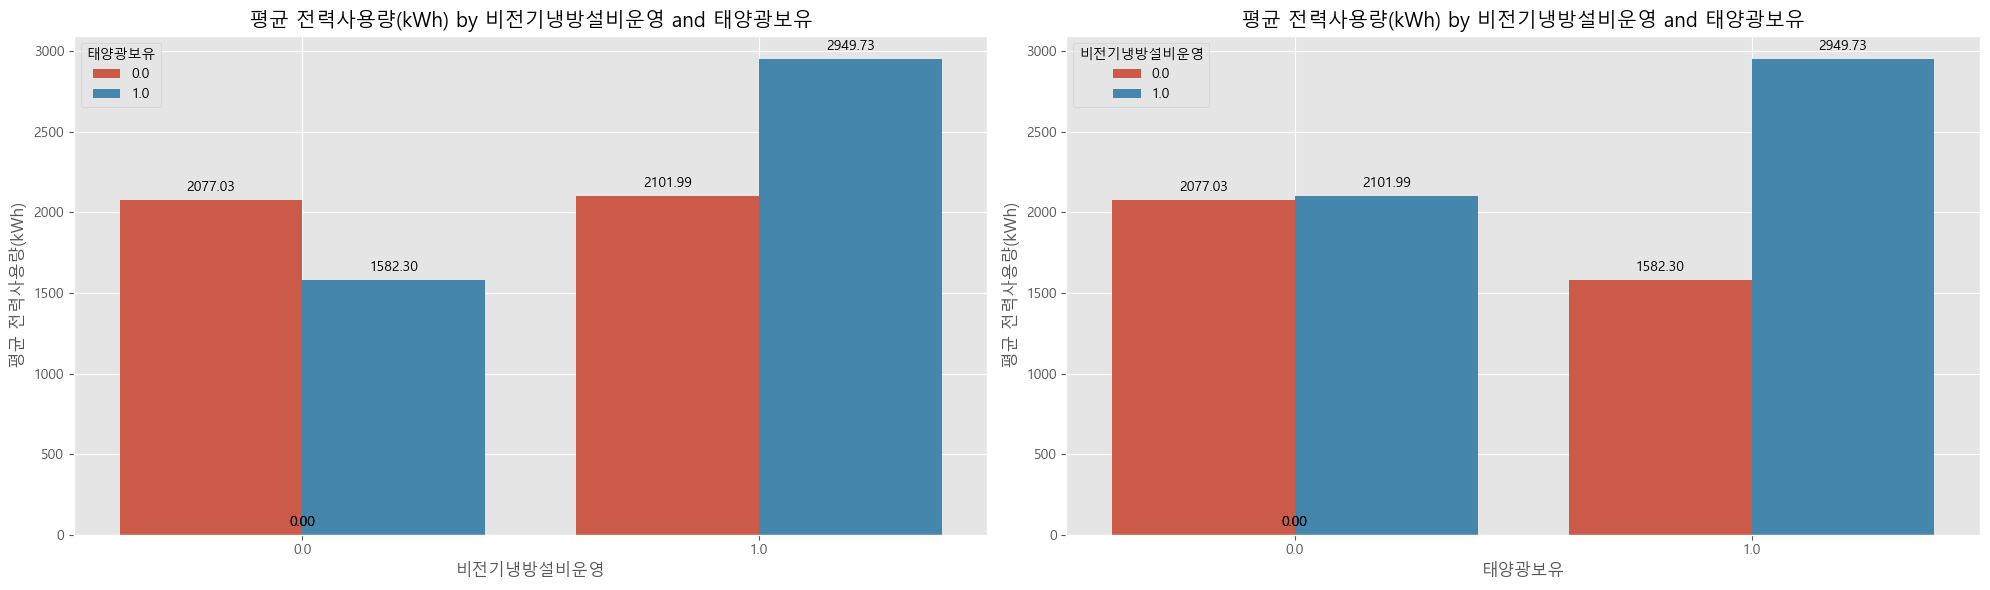

In [68]:
# 비전기냉방설비와 태양광의 유무에 따른 평균 전력사용량 비교
# 비전기냉방설비 X(0), O(1)
# 태양광 X(0), O(1)

plt.figure(figsize=(20, 6))

# 첫 번째 막대 그래프 : 비전기냉방설비운영
plt.subplot(1, 2, 1)
barplot1 = sns.barplot(data=solar_electric_df, x='비전기냉방설비운영', y='전력사용량(kWh)', hue='태양광보유')
# Bar 위에 통계량 추가
for p in barplot1.patches:
    height = p.get_height()
    barplot1.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.title('평균 전력사용량(kWh) by 비전기냉방설비운영 and 태양광보유')
plt.xlabel('비전기냉방설비운영')
plt.ylabel('평균 전력사용량(kWh)')
plt.legend(title='태양광보유')
plt.grid(True)

# 두 번째 막대 그래프: 태양광보유
plt.subplot(1, 2, 2)
barplot2 = sns.barplot(data=solar_electric_df, x='태양광보유', y='전력사용량(kWh)', hue='비전기냉방설비운영')
# Bar 위에 통계량 추가
for p in barplot2.patches:
    height = p.get_height()
    barplot2.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.title('평균 전력사용량(kWh) by 비전기냉방설비운영 and 태양광보유')
plt.xlabel('태양광보유')
plt.ylabel('평균 전력사용량(kWh)')
plt.legend(title='비전기냉방설비운영')
plt.grid(True)

# 그래프 출력
plt.tight_layout()
plt.show()

#### 시간별 총 전력사용량

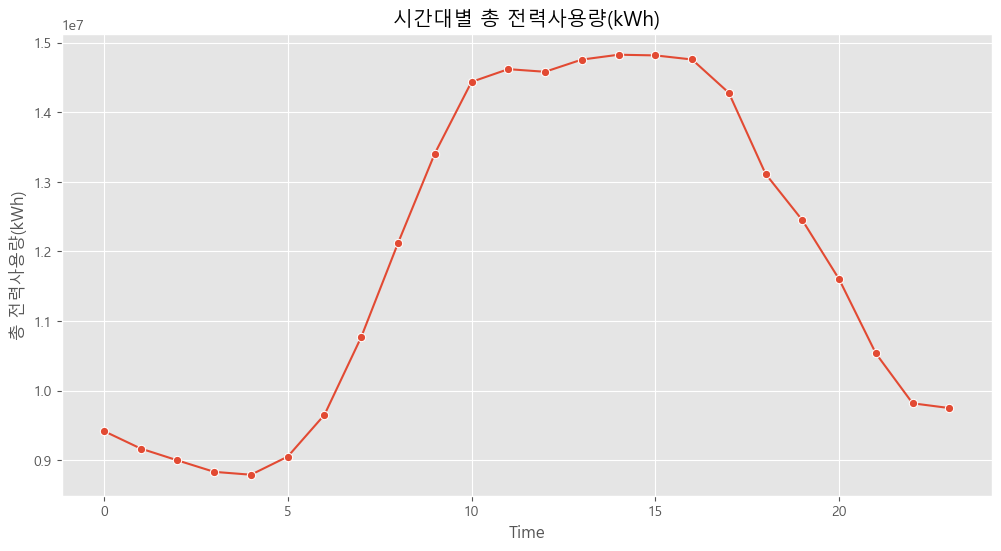

Total Energy Consumption by Building (sorted):
    num    전력사용량(kWh)
7     8  1.802822e+07
0     1  1.742828e+07
37   38  1.548091e+07
53   54  1.395327e+07
30   31  1.216721e+07
29   30  1.175290e+07
51   52  7.709893e+06
41   42  7.394168e+06
2     3  6.877562e+06
59   60  6.843735e+06
23   24  6.353866e+06
25   26  6.094885e+06
4     5  5.537600e+06
39   40  5.299907e+06
56   57  5.283545e+06
32   33  5.256051e+06
43   44  5.074681e+06
31   32  4.900977e+06
10   11  4.878400e+06
27   28  4.619722e+06
14   15  4.485905e+06
46   47  4.361430e+06
54   55  4.260146e+06
36   37  4.064729e+06
22   23  3.843717e+06
38   39  3.791050e+06
45   46  3.756721e+06
42   43  3.750606e+06
17   18  3.667178e+06
13   14  3.612057e+06
11   12  3.567661e+06
50   51  3.478280e+06
20   21  3.390671e+06
15   16  3.388090e+06
6     7  3.115362e+06
24   25  3.099127e+06
19   20  2.985595e+06
9    10  2.911415e+06
52   53  2.904809e+06
44   45  2.816417e+06
34   35  2.651912e+06
1     2  2.651825e+06
8     9

In [72]:
# 시간대별 총 전력 사용량 계산
hourly_total_energy = train_df.groupby('time')['전력사용량(kWh)'].sum().reset_index()

# 시간대별 총 전력 사용량 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_total_energy, x='time', y='전력사용량(kWh)', marker='o')
plt.title('시간대별 총 전력사용량(kWh)')
plt.xlabel('Time')
plt.ylabel('총 전력사용량(kWh)')
plt.grid(True)
plt.show()

# 각 건물 별 총 전력 사용량 계산 및 내림차순 정렬
building_total_energy = train_df.groupby('num')['전력사용량(kWh)'].sum().reset_index()
building_total_energy = building_total_energy.sort_values(by='전력사용량(kWh)', ascending=False)

# 각 건물 별 총 전력 사용량 출력
print("Total Energy Consumption by Building (sorted):")
print(building_total_energy)

In [78]:
train_df

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,time
date_time,,,,,,,,,,,,
2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6.0,1.0,0.0
2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6.0,1.0,1.0
2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0
2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6.0,1.0,3.0
2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-24 19:00:00,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8.0,24.0,19.0
2020-08-24 20:00:00,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8.0,24.0,20.0
2020-08-24 21:00:00,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8.0,24.0,21.0


In [77]:
# 건물 1: 태양광 X, 건물 8, 38: 태양광 O

# 건물 1, 8, 38을 제외한 나머지 건물 선택
buildings_to_exclude = [1, 8, 38]
filtered_df = train_df[~train_df['num'].isin(buildings_to_exclude)].copy()

# 시간대별로 총 전력 사용량 계산
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'])
filtered_df['time'] = filtered_df['date_time'].dt.hour

# 시간대별 총 전력 사용량 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='time', y='전력사용량(kWh)', estimator='sum', ci=None)
plt.title('Total Energy Consumption by Hour (Excluding Buildings 1, 8, 38)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Energy Consumption (kWh)')
plt.grid(True)
plt.show()

#=====================================================
# 시간대별 총 전력 사용량을 태양광 발전량 여부에 따라 나누기
plt.figure(figsize=(12, 6))

# 태양광 발전량이 있는 건물의 시간대별 총 전력 사용량
sns.lineplot(data=filtered_df[filtered_df['태양광보유'] == 1], x='time', y='전력사용량(kWh)', estimator='sum', label='Solar Present')

# 태양광 발전량이 없는 건물의 시간대별 총 전력 사용량
sns.lineplot(data=filtered_df[filtered_df['태양광보유'] == 0], x='time', y='전력사용량(kWh)', estimator='sum', label='Solar Absent')

plt.title('Total Energy Consumption by Hour (Solar Present vs Solar Absent)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Energy Consumption (kWh)')
plt.grid(True)
plt.legend()
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\USER\projects\2week\venv\lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'date_time'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\USER\projects\2week\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_5896\2171582812.py", line 8, in <module>
    filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'])
  File "c:\Us

In [ ]:
plt.figure(figsize=(20, 8))

# 첫 번째 그래프: 태양광 발전량 여부에 따른 전력 사용량 그래프 (train_df)
plt.subplot(2, 2, 1)
sns.lineplot(data=train_df[train_df['비전기냉방설비운영'] == 1], x='hour', y='전력사용량(kWh)', estimator='sum', label='Non-Electric')
sns.lineplot(data=train_df[train_df['비전기냉방설비운영'] == 0], x='hour', y='전력사용량(kWh)', estimator='sum', label='Electric')
plt.title('Total Energy Consumption by Hour (Non-Electric vs Electric) - train_df')
plt.xlabel('Hour of Day')
plt.ylabel('Total Energy Consumption (kWh)')
plt.grid(True)
plt.legend()

# 두 번째 그래프: 태양광 발전량 여부에 따른 전력 사용량 그래프 (filtered_df)
plt.subplot(2, 2, 2)
sns.lineplot(data=filtered_df[filtered_df['비전기냉방설비운영'] == 1], x='hour', y='전력사용량(kWh)', estimator='sum', label='Non-Electric')
sns.lineplot(data=filtered_df[filtered_df['비전기냉방설비운영'] == 0], x='hour', y='전력사용량(kWh)', estimator='sum', label='Electric')
plt.title('Total Energy Consumption by Hour (Non-Electric vs Electric) - filtered_df')
plt.xlabel('Hour of Day')
plt.ylabel('Total Energy Consumption (kWh)')
plt.grid(True)
plt.legend()

# 세 번째 그래프: 태양광 발전량 및 비전기 여부에 따른 전력 사용량 그래프 (train_df)
plt.subplot(2, 2, 3)
sns.lineplot(data=train_df[(train_df['태양광보유'] == 1) & (train_df['비전기냉방설비운영'] == 1)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Present & Non-Electric')
sns.lineplot(data=train_df[(train_df['태양광보유'] == 1) & (train_df['비전기냉방설비운영'] == 0)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Present & Electric')
sns.lineplot(data=train_df[(train_df['태양광보유'] == 0) & (train_df['비전기냉방설비운영'] == 1)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Absent & Non-Electric')
sns.lineplot(data=train_df[(train_df['태양광보유'] == 0) & (train_df['비전기냉방설비운영'] == 0)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Absent & Electric')
plt.title('Total Energy Consumption by Hour (Solar & Electric Status) - eda_df')
plt.xlabel('Hour of Day')
plt.ylabel('Total Energy Consumption (kWh)')
plt.grid(True)
plt.legend()

# 네 번째 그래프: 태양광 발전량 및 비전기 여부에 따른 전력 사용량 그래프 (filtered_df)
plt.subplot(2, 2, 4)
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 1) & (filtered_df['비전기냉방설비운영'] == 1)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Present & Non-Electric')
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 1) & (filtered_df['비전기냉방설비운영'] == 0)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Present & Electric')
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 0) & (filtered_df['비전기냉방설비운영'] == 1)], x='hour', y='전력사용량(kWh)', estimator='sum', label='Solar Absent & Non-Electric')
sns.lineplot(data=filtered_df[(filtered_df['태양광보유'] == 

### 1.2.3 기후 정보

### 1.2.4 시간/주말/주중

### 1.2.5 피크타임 확인

## 1.3 시계열 분해 : ACF, PACF, CCF

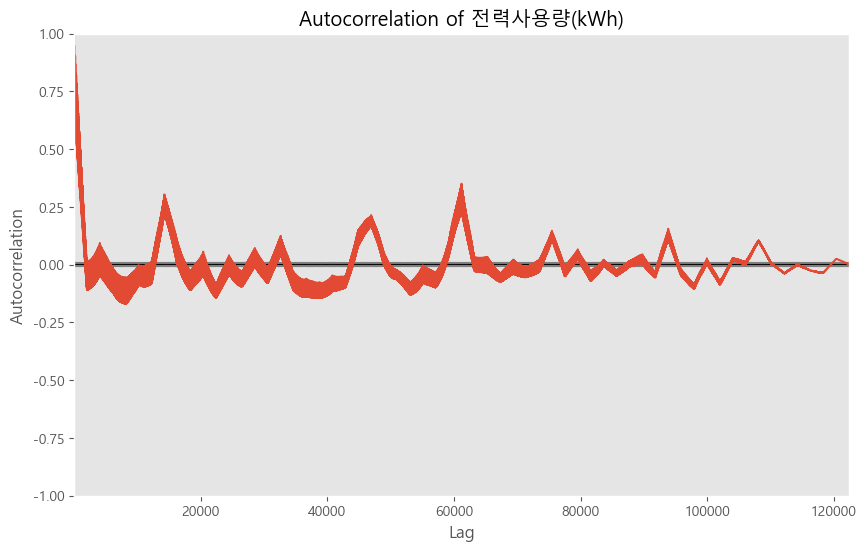

In [53]:
# ACF(Autocorrelation Function, 자기상관함수) 시각화
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# 'date_time' 인덱스로 설정
train_df.set_index('date_time', inplace=True)

# '전력사용량(kWh)'열을 autocorrelation(자기상관) 시각화
plt.figure(figsize=(10, 6))
autocorrelation_plot(train_df['전력사용량(kWh)'])
plt.title('Autocorrelation of 전력사용량(kWh)')
plt.show()

# 2. 모델 탐색⭐️

## 2-1. ARIMA

## 2-2. LSTM

## 2-3. LGBM

## 2-4. XGBoost